Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. 
К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from operator import attrgetter
import seaborn as sns
import scipy as sci
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

# ЗАДАЧА №1

In [17]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [18]:
# Перевожу ts в dt
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')

In [19]:
auth_data.head()


,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


In [20]:
reg_data.head()


,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [21]:
# Объединяю таблицы по uid
merge_df = pd.merge(reg_data, auth_data, on='uid', how='left')

In [22]:
# Фильтрую данные только за 2020 год по дате регистрации, чтобы видеть актуальные данные за последние 9 месяцев
merge_df = merge_df[merge_df['reg_ts'].dt.year == 2020]

In [23]:
# Функция для подсчёта retention. На вход ожидается объединённая таблица с днями регистрации и авторизации,
# количество периодов (дни с начала года, необязательный параметр), количество когорт (необязательный параметр)
def calc_retention(union_table, max_periods=30, max_cohorts=10):
    
    # Присваиваю когорты на основе даты регистрации для каждого пользователя
    union_table['cohort_day'] = union_table['reg_ts'].dt.to_period('D')

    # Рассчитываю номер периода в днях
    union_table['period_num_day'] = np.floor((union_table['auth_ts'] - union_table['reg_ts']).apply(attrgetter('days')))

    # Агрегирую данные по когортам и рассчитанному номеру периода
    df_cohort = union_table.groupby(['cohort_day', 'period_num_day']).agg(n_users=('uid', 'nunique')).reset_index()

    # Создаю сводную таблицу для когортного анализа
    cohort_pivot = df_cohort.pivot_table(index='cohort_day', columns='period_num_day', values='n_users')
    
    # Ограничиваю количество периодов на тепловой карте
    cohort_pivot = cohort_pivot.iloc[:, :max_periods]
    
    # Ограничиваю количество когорт на тепловой карте   
    cohort_pivot = cohort_pivot.iloc[-max_cohorts:, :]

    # Рассчитываю размеры когорт (первый столбец сводной таблицы)
    cohort_size = cohort_pivot.iloc[:, 0]

    # Вычисляю коэффициенты удержания, деля на размер когорты
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    
    # Строю тепловую карту когортного анализа
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(20, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
        sns.heatmap(retention_matrix.iloc[:, 1:],
                    mask=retention_matrix.iloc[:, 1:].isnull(),
                    annot=True,
                    fmt='.0%',
                    cmap='RdYlGn',
                    ax=ax[1])
        ax[1].set_title('Daily Retention', fontsize=16)
        ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df,
                    annot=True,
                    cbar=False,
                    fmt='g',
                    cmap=white_cmap,
                    ax=ax[0])

        fig.tight_layout()
        plt.show()
        
    # Возвращаю результат расчёта
    return sns.axes_style("white")

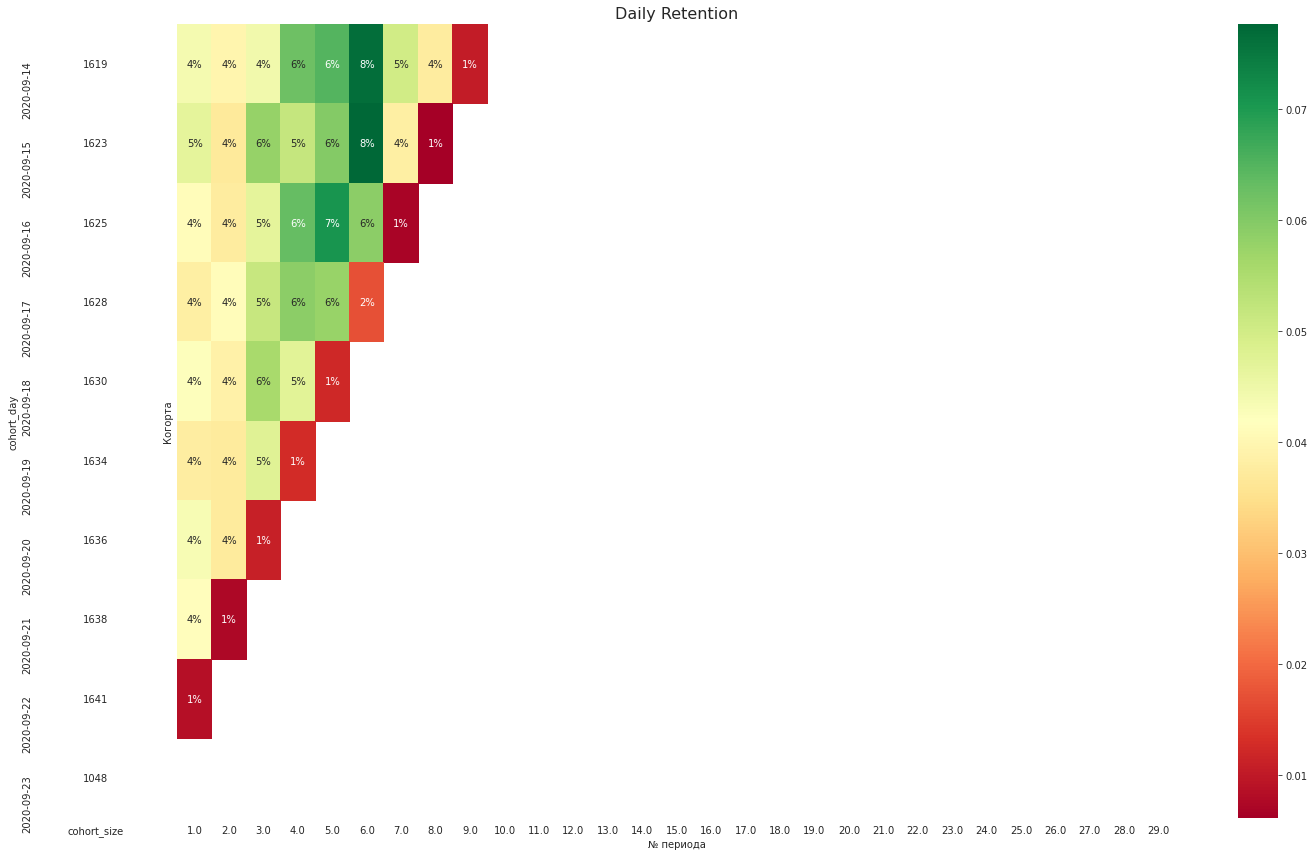

{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'grid.color': '.8',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

In [24]:
# Работа функции для расчёта когортного анализа
calc_retention(merge_df)

# ЗАДАЧА №2


In [25]:
data = pd.read_csv('~/shared/problem2.csv', sep=';')
data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [26]:
# Смотрю типы данных, количество пустых строк
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [27]:
# Рассчитываю общее кол-во человек в кажддой группе

control_group = data[data['testgroup'] == 'a']
test_group = data[data['testgroup'] == 'b']

print(f'Всего людей: a = {len(control_group)} | b = {len(test_group)}')

# Рассчитываю кол-во платящих пользователей в каждой группе
pay_control = (control_group['revenue'] > 0).sum()
pay_test = (test_group['revenue'] > 0).sum()

print(f'Платящие: a = {pay_control} | b = {pay_test}')

# Рассчитываю конверсию в платящего пользователя
cr_control = pay_control / len(control_group)
cr_test = pay_test / len(test_group)

print(f'Конверсия: a = {round(cr_control, 5)} | b = {round(cr_test, 5)}')

# Рассчитываю ARPU
arpu_control = control_group['revenue'].mean()
arpu_test = test_group['revenue'].mean()

print(f'Средний доход на пользователя: a = {round(arpu_control, 3)} | b = {round(arpu_test, 3)}')

# Рассчитываю ARPPU
arppu_control = control_group[control_group['revenue'] > 0]['revenue'].mean()
arppu_test = test_group[test_group['revenue'] > 0]['revenue'].mean()

print(f'Средний доход на платящего пользователя: a = {round(arppu_control, 3)} | b = {round(arppu_test, 3)}')



Всего людей: a = 202103 | b = 202667
Платящие: a = 1928 | b = 1805
Конверсия: a = 0.00954 | b = 0.00891
Средний доход на пользователя: a = 25.414 | b = 26.751
Средний доход на платящего пользователя: a = 2663.998 | b = 3003.658


In [28]:
# Для проверки статистической значимости ARPU использую t-тест
# Не проверяю нормальность выборки, т.к. объём выборки большой
# При приблизительном равенстве размера выборок для t-теста неважно,
# различаются ли дисперсии, но всё же буду использовать вариант Уэлча

t_test, p_value_arpu = sci.stats.ttest_ind(control_group['revenue'], test_group['revenue'], equal_var=False)

print(f'Т-статистика: {t_test} | p-value: {p_value_arpu}')

Т-статистика: -0.6234876562792212 | p-value: 0.5329647014130866


In [29]:
# Для проверки статистической значимости ARPPU использую t-тест по тем же причинам, что и для ARPU
# Так же использую вариант Уэлча, чтобы не думать о разнице дисперсий

t_test, p_value_arppu = sci.stats.ttest_ind(control_group[control_group['revenue'] > 0]['revenue'],
                                            test_group[test_group['revenue'] > 0]['revenue'], equal_var=False)

print(f'Т-статистика: {t_test} | p-value: {p_value_arppu}')

Т-статистика: -1.6446302664300838 | p-value: 0.10020780398916015


In [30]:
# Для проверки статистической значимости конверсии использую z-тест для пропорций
# Не проверяю нормальность выборки, т.к. объём выборки большой

z_test, p_value_cr = proportions_ztest([pay_control, pay_test], [len(control_group), len(test_group)])

print(f'Z-статистика: {z_test} | p-value: {p_value_cr}')

Z-статистика: 2.108028495889841 | p-value: 0.035028524642854865


# Выводы по статистическому анализу:
1. По ARPU показатель p-value > 0,05 => различия не являются достоверными.
2. По ARPPU показатель p-value > 0,05 => различия не являются достоверными.
3. По конверсии показатель p-value < 0,05 => различия являются достоверными.

# Ответы на поставленные вопросы:

1. Какие метрики стоит проанализировать для принятия правильного решения и как?
С целью принятию правильного решения по вопросу акционного предложения стоит проанализировать метрики: ARPU, ARRPU, конверсию в платящего пользователя.

2. Какой набор предложений можно считать лучшим?
По результам проведенного статистического анализа, можно сделать вывод, что предложенные акционные предложения в контрольной группе не оказали значимых различий на доход от пользователей. Но повлияли на увеличение количества платящих пользователей (что является следствием увеличения конверсии в платящего пользователя).

Предположения о причинах неизменности дохода:
1. Не учёт времени года (праздников, мировых событий) при введении акционных предложений.
2. Отсутствие новизны в акционных предложениях.
3. Слишком низкая привлекательность акционного предложения.


# ЗАДАЧА №3
Метрики, которые можно использовать для оценки результатов игровых событий:
    1. PPE - players per event. Доля игроков, которая приняла участие в событии, относительно доли игроков, которые авторизовались в игре за время проведения ивента.
    Здесь мы сможем посмотреть, мотивировала ли предложенная награда и тематика участвовать игроков в событии. (расчёт: участники события/все авторизованные игроки за время события).
    2. MLF - mode levels finished. Количество пройденных этапов относительно количества разработанных для проведения события.
    Здесь можно увидеть достаточно ли уровней для прохождения участниками события. (расчёт: мода пройденных уровней участниками/все уровни).
    3. MLС - mode levels complexity. Мода количества попыток, которое пользователь потратил на прохождение одного уровня. (расчёт: мода пройденных уровней/количество пройденных уровней)
    4. ARPU (average revenue per user) - средний чек по участнику события.
    5. CPA (cost per action) - стоимость привлечения участника события.
    6. Total revenue - общий доход от события.
    7. Conversion rate - конверсия в платящего пользователя.
    8. Время, которое пользователь провёл в игре относительно времени в игре до события. (среднее время пользователя в игре во время события/среднее время пользователя в игре вне события).
    9. Процент игроков полностью завершивших событие.(количество участников завершивших событие/количество всех участников)
    
При усложнении механики можно начать учитывать количество поражений для более точного отслеживания сложности механики,
но мне кажется, что это избыточно.(Т.к. MLF и MLC всё ещё будут отражать сложность)

